In [1]:
%matplotlib notebook
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem

In [2]:
def draw_hidden_ad_hist(folder, title="AD validation", savepath=None,
                        ad={"knn_ad.txt": "knn", "distances.txt": "distances", "densities.txt": "densities"},
                        test_errors_filename="test_errors.txt",
                        figsize=(8, 4)):
    ads = {ad[filename]: np.loadtxt(os.path.join(folder, filename)).astype(bool) for filename in ad}
    test_errors = np.loadtxt(os.path.join(folder, test_errors_filename))

    fig, ax = plt.subplots(len(ads), 1, figsize=figsize)
    if title:
        fig.suptitle(title)
    for i, (ad_name, ad) in enumerate(ads.items()):
        ax[i].text(0.5, 0.8, ad_name, fontsize=12, ha='center', va='center', transform=ax[i].transAxes)
        ax[i].hist(test_errors[ad], alpha=0.5, label='ad', color='green')
        ax[i].hist(test_errors[~ad], alpha=0.5, label='non-ad', color='red')
        ax[i].legend(loc='upper right')
        ax[i].set_xlim(0, max(test_errors)*1.1)
        ax[i].set_ylabel('frequency')
        if i != len(ads)-1:
            ax[i].set_xticks([])
    ax[-1].set_xlabel('absolute error')
    plt.subplots_adjust(hspace=0.05)
    plt.show()
    if savepath:
        fig.savefig(savepath)

## AD for 1-metal model (on fingerprints)

<IPython.core.display.Javascript object>


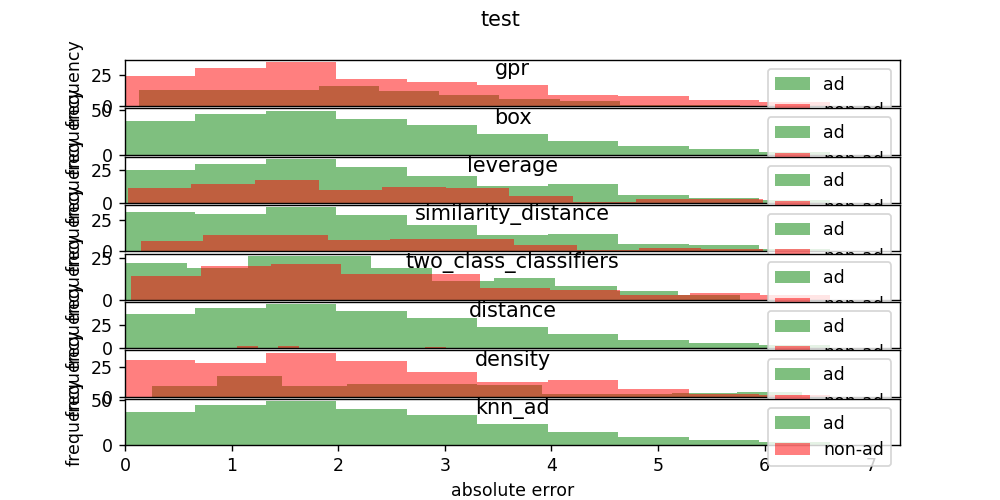

<IPython.core.display.Javascript object>


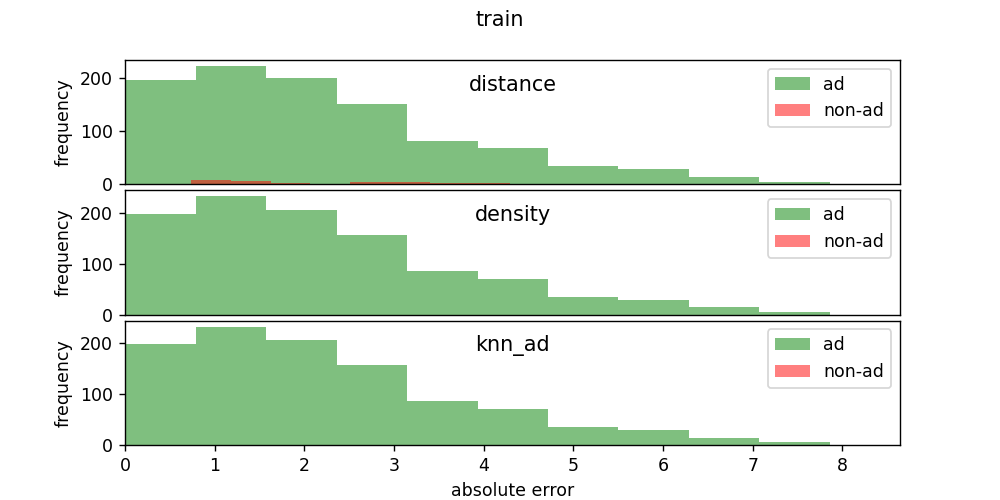

In [5]:
draw_hidden_ad_hist("../Output/TestOneM_regression_2023_03_03_17_44_37/applicability_domain", title="test",
    ad={
        "hidden_gpr_ad.txt": "gpr",
        "hidden_box_ad.txt": "box",
        "hidden_leverage_ad.txt": "leverage",
        "hidden_similarity_distance_ad.txt": "similarity_distance",
        "hidden_two_class_classifiers_ad.txt": "two_class_classifiers",
        "distances.txt": "distance",
        "densities.txt": "density",
        "knn_ad.txt": "knn_ad"
    },
    test_errors_filename="test_errors.txt")
draw_hidden_ad_hist("../Output/TestOneM_regression_2023_03_03_17_44_37/applicability_domain", title="train",
    ad={
#         "hidden_gpr_ad.txt": "gpr",
#         "hidden_box_ad.txt": "box",
#         "hidden_leverage_ad.txt": "leverage",
#         "hidden_similarity_distance_ad.txt": "similarity_distance",
#         "hidden_two_class_classifiers_ad.txt": "two_class_classifiers",
        "distances_train.txt": "distance",
        "densities_train.txt": "density",
        "knn_ad_train.txt": "knn_ad"
    },
    test_errors_filename="train_errors.txt")

## AD for GeneralModel (on hidden states)

In [3]:
from sklearn.metrics import r2_score, mean_squared_error

def delta_r2(test_true, test_predicted, ad):
    return r2_score(test_true[ad], test_predicted[ad]) - r2_score(test_true, test_predicted)
def delta_mse(test_true, test_predicted, ad):
    return mean_squared_error(test_true[ad], test_predicted[ad]) - mean_squared_error(test_true, test_predicted)

In [5]:
df = pd.DataFrame()
folder = {}
ads = {}
ad_files={"hidden_gpr_ad.txt": "gpr",
    "hidden_box_ad.txt": "box",
    "hidden_leverage_ad.txt": "leverage",
    "hidden_similarity_distance_ad.txt": "similarity_distance",
    "hidden_two_class_classifiers_ad.txt": "bin_classifier",
    "new_two_class_classifiers_ad.txt": "new_bin_classifier",
    "distances.txt": "distance",
    "densities.txt": "density",
    "knn_ad.txt": "knn_ad"}
for metal in ["Cd", "Er", "Cm"]:
    folder[metal] = f"../Output/GeneralModel_1_seed15_regression_2023_03_09_10_14_27/{metal}_ad"
    ads[metal] = {ad_files[filename]: np.loadtxt(os.path.join(folder[metal], filename)).astype(bool) for filename in ad_files}
    test_true = np.loadtxt(os.path.join(folder[metal], "test_true.txt"))
    test_pred = np.loadtxt(os.path.join(folder[metal], "test_pred.txt"))

    df = pd.concat([df, pd.concat([pd.DataFrame({f"delta_r2_{metal}": [delta_r2(test_true, test_pred, ad)],
                                                 f"delta_mse_{metal}": [delta_mse(test_true, test_pred, ad)]},
                                                index=[ad_name]) for ad_name, ad in ads[metal].items()])], axis=1)

In [6]:
df

,delta_r2_Cd,delta_mse_Cd,delta_r2_Er,delta_mse_Er,delta_r2_Cm,delta_mse_Cm
gpr,0.069854,-1.266203,0.000000,0.000000,-0.004412,0.099478
box,0.000910,-0.017341,0.000000,0.000000,-0.001641,0.033209
leverage,0.000019,-0.038385,-0.000027,0.004627,-0.006762,0.065136
similarity_distance,0.017804,-0.397706,0.000000,0.000000,-0.003684,0.027585
bin_classifier,0.037911,-1.278904,-0.000055,0.004219,-0.003684,0.027585
new_bin_classifier,0.000000,0.000000,0.005950,-0.207464,0.000000,0.000000
distance,0.009217,-0.193651,0.000000,0.000000,0.000000,0.000000
density,-0.767956,12.590837,-0.000558,0.027170,-0.082138,0.588945
knn_ad,0.008956,-0.340552,0.000472,-0.004882,0.000000,0.000000


<IPython.core.display.Javascript object>


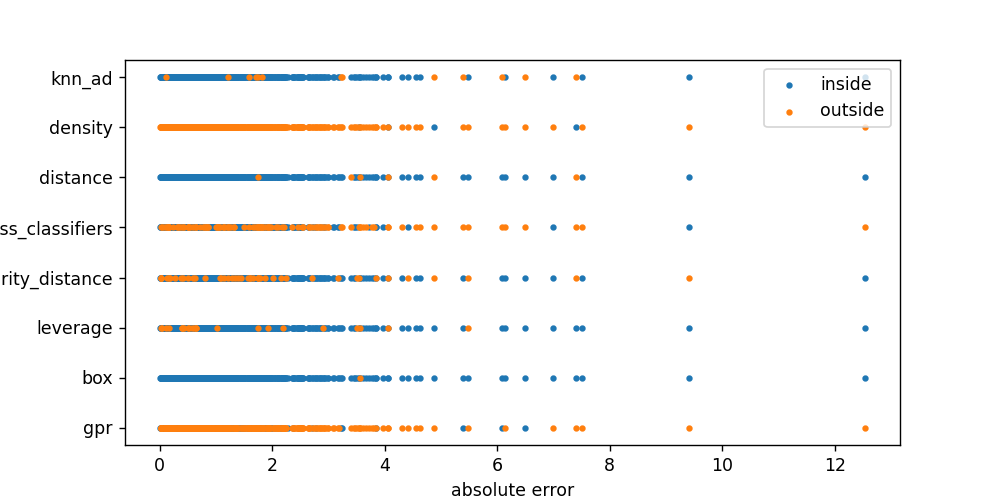

In [11]:
metal="Cd"

test_errors = np.loadtxt(os.path.join(folder[metal], "test_errors.txt"))
fig, ax = plt.subplots(figsize=(8, 4))
# ax.set_title("title")
for i, ad in enumerate(ads[metal].values()):
    y = np.ones_like(test_errors) * i
    inside = ax.scatter(test_errors[ad], y[ad], c="C0", label="inside", s=7)
    outside = ax.scatter(test_errors[~ad], y[~ad], c="C1", label="outside", s=7)
ax.legend(handles=[inside, outside])
ax.set_xlabel("absolute error")
ax.set_yticks(range(len(ads[metal].keys())), ads[metal].keys())
plt.show()

<IPython.core.display.Javascript object>


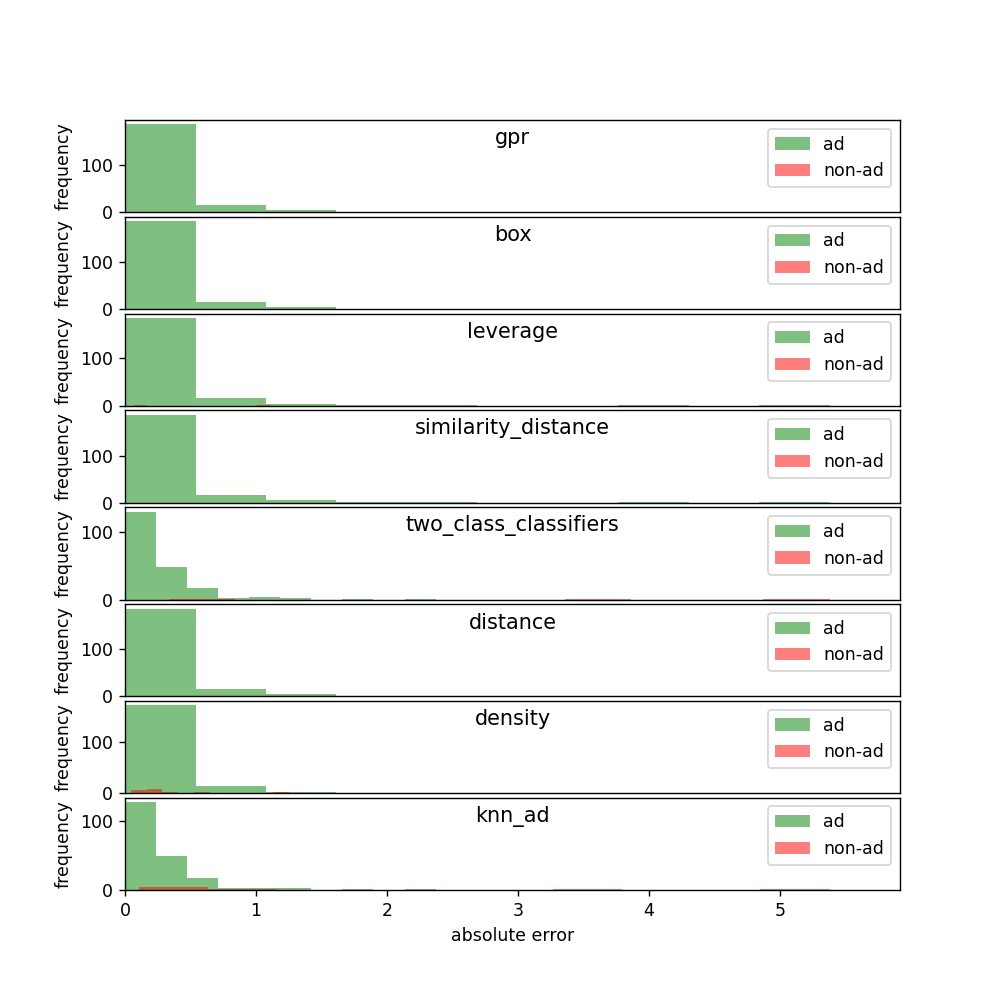

In [12]:
metal = "Er"
draw_hidden_ad_hist(f"../Output/GeneralModel_1_seed15_regression_2023_03_09_10_14_27/{metal}_ad",
                    title=None,
                    ad=ad_files,
                    test_errors_filename="test_errors.txt",
                   figsize=(8, 8))